In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import block_diag
#自定义工具
import ff
import vis
import regula

import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')
plt.rcParams.update({"font.size":16})

In [14]:
shape = (8, 8, 8) #nz ny-EW nx-SN
area = (0, 1600, 0, 1600, 200, 1000) #NS EW Down
nshape = (32, 32) 
narea = (-400, 2000, -400, 2000) #NS, EW
density=np.zeros(shape)
    
nz = shape[0]
ny = shape[1]
nx = shape[2]
    
density[: , : , : ] = 0.001
i = 0; j = 0; k = 0
for i in range(7):
    density[ i+1, 2*i:2*i+3, 3:5] = 0.5
    #density[ 1, 7 : 16, :] = 0.8

ncell = nz*ny*nx     
    #global kernel kernal:核矩阵， gob s:重力观测值， depth:深度信息
kernel, gobs, depthz = ff.greenmat(shape = shape, nshape = nshape, density = density,
                            area = area, narea = narea, noisefree = True)

In [15]:
#构建光滑项
Lx = regula.Lx(shape)
print("Lx shape:", Lx.shape)
Ly = regula.Ly(shape)
print("Ly shape:", Ly.shape)
Lz = regula.Lz(shape)
print("Ly shape:", Lz.shape)

# x方向一阶光滑强度
alpha = 0.001
# y方向一阶光滑强度
beta = 0.001
# z方向一阶光滑强度
zeta = 0.001
# 数据可信度
Cd_c = 1
# 模型可信度
Cp_c = 1

norm = alpha*np.dot(Lx.T, Lx) + beta*np.dot(Ly.T, Ly) + zeta*np.dot(Lz.T, Lz)

## 定义参考模型
Cd = np.eye(gobs.shape[0])/Cd_c
print("Cd shape:", Cd.shape)
Cd_inv = np.linalg.pinv(Cd)
print("Cd_inv shape:", Cd_inv.shape)

ref_density = density.ravel()
ref_density = ref_density.reshape(512, 1)
Cp = np.eye(512)/Cp_c
Cp_inv = np.linalg.pinv(Cp)

print("Cp_inv shape:", Cp_inv.shape)
print("Ref density shape:", ref_density.shape)
print("Kernal shape:", kernel.shape)
print("G_obs shape:", gobs.shape)

m_lse1 = np.linalg.pinv(np.dot(np.dot(kernel.T, Cd_inv), kernel) + Cp_inv + norm)
print("m_lse1 shape:", m_lse1.shape)
m_lse2 = np.dot(np.dot(kernel.T, Cd_inv), gobs) + np.dot(Cp_inv, ref_density)
print("m_lse2 shape:", m_lse2.shape)
result = np.dot(m_lse1, m_lse2)
res_lse = np.array(result).reshape(8, 8, 8)
print("Result shape:", res_lse.shape)
predict = np.mat(kernel)*np.transpose(np.mat(res_lse.ravel()))

Lx shape: (448, 512)
Ly shape: (448, 512)
Ly shape: (448, 512)
Cd shape: (1024, 1024)
Cd_inv shape: (1024, 1024)
Cp_inv shape: (512, 512)
Ref density shape: (512, 1)
Kernal shape: (1024, 512)
G_obs shape: (1024, 1)
m_lse1 shape: (512, 512)
m_lse2 shape: (512, 1)
Result shape: (8, 8, 8)


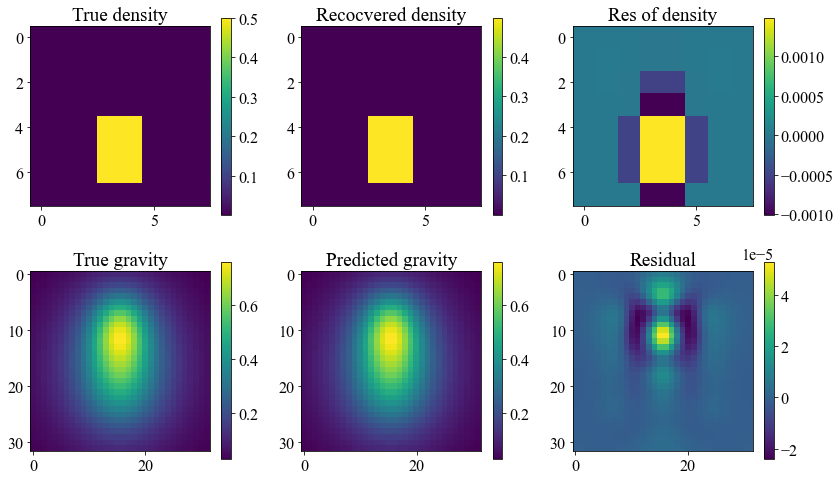

In [16]:
dep_index = 3
plt.figure(figsize=(12, 7))
plt.subplot(231)
plt.imshow(density[dep_index, :, :])
plt.title("True density")
plt.colorbar()

plt.subplot(232)
plt.imshow(res_lse[dep_index, :, :])
plt.title("Recocvered density")
plt.colorbar()

plt.subplot(233)
plt.imshow(density[dep_index, :, :]- res_lse[dep_index, :, :])
plt.title("Res of density")
plt.colorbar()

plt.subplot(234)
plt.imshow(gobs.reshape(nshape).T)
plt.title("True gravity")
plt.colorbar()

plt.subplot(235)
plt.imshow(predict.reshape(nshape).T)
plt.title("Predicted gravity")
plt.colorbar()

plt.subplot(236)
plt.imshow(gobs.reshape(nshape).T - predict.reshape(nshape).T)
plt.title("Residual")
plt.colorbar()
plt.tight_layout()

In [17]:
%%time
import abic
ref_density = density.ravel()
ref_density = ref_density.reshape(512, 1)
x0 = [1, 1, 1, 1, 1]
res = minimize(abic.minimize_datamisfit(gobs, kernel, ref_density, shape),
               x0=x0, method = 'SLSQP')

CPU times: total: 5min 17s
Wall time: 2min 12s


In [18]:
res['x']

array([-3.02941115, -8.37323575, -8.01852313, 10.43249935, 13.98695524])

In [19]:
#构建光滑项
Lx = regula.Lx(shape)
print("Lx shape:", Lx.shape)
Ly = regula.Ly(shape)
print("Ly shape:", Ly.shape)
Lz = regula.Lz(shape)
print("Ly shape:", Lz.shape)

# x方向一阶光滑强度
alpha = np.exp(res['x'][0])
# y方向一阶光滑强度
beta = np.exp(res['x'][1])
# z方向一阶光滑强度
zeta = np.exp(res['x'][2])
# 数据可信度
Cd_c = np.exp(res['x'][3])
# 模型可信度
Cp_c = np.exp(res['x'][4])

norm = alpha*np.dot(Lx.T, Lx) + beta*np.dot(Ly.T, Ly) + zeta*np.dot(Lz.T, Lz)

## 定义参考模型
Cd = np.eye(gobs.shape[0])/Cd_c
print("Cd shape:", Cd.shape)
Cd_inv = np.linalg.pinv(Cd)
print("Cd_inv shape:", Cd_inv.shape)

ref_density = density.ravel()
ref_density = ref_density.reshape(512, 1)
Cp = np.eye(512)/Cp_c
Cp_inv = np.linalg.inv(Cp)

print("Cp_inv shape:", Cp_inv.shape)
print("Ref density shape:", ref_density.shape)
print("Kernal shape:", kernel.shape)
print("G_obs shape:", gobs.shape)

m_lse1 = np.linalg.pinv(np.dot(np.dot(kernel.T, Cd_inv), kernel) + Cp_inv + norm)
print("m_lse1 shape:", m_lse1.shape)
m_lse2 = np.dot(np.dot(kernel.T, Cd_inv), gobs) + np.dot(Cp_inv, ref_density)
print("m_lse2 shape:", m_lse2.shape)
result = np.dot(m_lse1, m_lse2)
res_lse = np.array(result).reshape(8, 8, 8)
print("Result shape:", res_lse.shape)
predict = np.mat(kernel)*np.transpose(np.mat(res_lse.ravel()))

Lx shape: (448, 512)
Ly shape: (448, 512)
Ly shape: (448, 512)
Cd shape: (1024, 1024)
Cd_inv shape: (1024, 1024)
Cp_inv shape: (512, 512)
Ref density shape: (512, 1)
Kernal shape: (1024, 512)
G_obs shape: (1024, 1)
m_lse1 shape: (512, 512)
m_lse2 shape: (512, 1)
Result shape: (8, 8, 8)


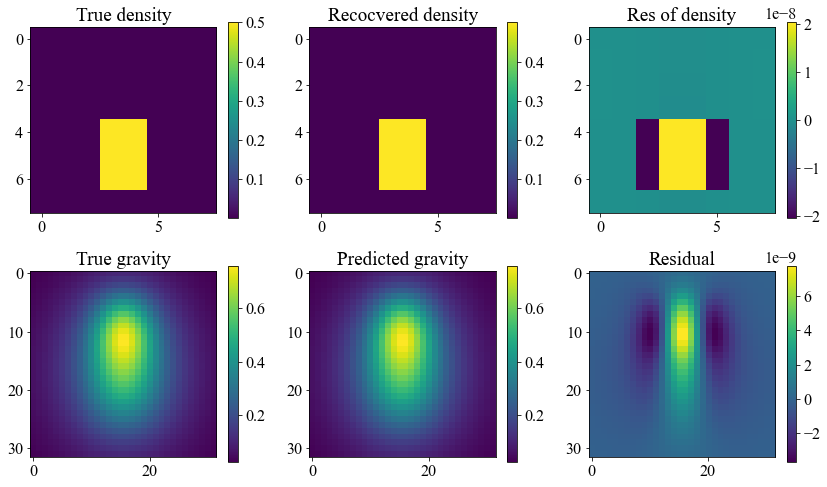

In [20]:
dep_index = 3
plt.figure(figsize=(12, 7))
plt.subplot(231)
plt.imshow(density[dep_index, :, :])
plt.title("True density")
plt.colorbar()

plt.subplot(232)
plt.imshow(res_lse[dep_index, :, :])
plt.title("Recocvered density")
plt.colorbar()

plt.subplot(233)
plt.imshow(density[dep_index, :, :]- res_lse[dep_index, :, :])
plt.title("Res of density")
plt.colorbar()

plt.subplot(234)
plt.imshow(gobs.reshape(nshape).T)
plt.title("True gravity")
plt.colorbar()

plt.subplot(235)
plt.imshow(predict.reshape(nshape).T)
plt.title("Predicted gravity")
plt.colorbar()

plt.subplot(236)
plt.imshow(gobs.reshape(nshape).T - predict.reshape(nshape).T)
plt.title("Residual")
plt.colorbar()
plt.tight_layout()

In [21]:
import abic
ref_density = density.ravel()
ref_density = ref_density.reshape(512, 1)
x0 = [0.5, 0.5, 0.5, 1, 1]
res = minimize(abic.minimize_abic(gobs, kernel, ref_density, shape), x0=x0, method = 'SLSQP')

d:\OneDrive\OneDrive - 中国地震局地球物理研究所\Github\Gravity-inversion-method\ABIC反演\abic.py:80: RuntimeWarning: overflow encountered in exp
  Cp_c = np.exp(x[4])+1e-9
d:\OneDrive\OneDrive - 中国地震局地球物理研究所\Github\Gravity-inversion-method\ABIC反演\abic.py:72: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(x[0])+1e-9
d:\OneDrive\OneDrive - 中国地震局地球物理研究所\Github\Gravity-inversion-method\ABIC反演\abic.py:76: RuntimeWarning: overflow encountered in exp
  zeta = np.exp(x[2])+1e-9


In [22]:
res['x']

array([ -19.92474366, -253.36253293,  -31.63910373,  -95.95846927,
         22.60505272])

In [23]:
#构建光滑项
Lx = regula.Lx(shape)
print("Lx shape:", Lx.shape)
Ly = regula.Ly(shape)
print("Ly shape:", Ly.shape)
Lz = regula.Lz(shape)
print("Ly shape:", Lz.shape)

# x方向一阶光滑强度
alpha = np.exp(res['x'][0])+1e-9
# y方向一阶光滑强度
beta = np.exp(res['x'][1])+1e-9
# z方向一阶光滑强度
zeta = np.exp(res['x'][2])+1e-9
# 数据可信度
Cd_c = np.exp(res['x'][3])+1e-9
# 模型可信度
Cp_c = np.exp(res['x'][4])+1e-9

norm = np.dot(Lx.T, Lx)/alpha + np.dot(Ly.T, Ly)/beta + np.dot(Lz.T, Lz)/zeta

## 定义参考模型
Cd = np.eye(gobs.shape[0])/Cd_c
print("Cd shape:", Cd.shape)
Cd_inv = np.linalg.pinv(Cd)
print("Cd_inv shape:", Cd_inv.shape)

ref_density = density.ravel()
ref_density = ref_density.reshape(512, 1)
Cp = np.eye(512)/Cp_c
Cp_inv = np.linalg.pinv(Cp)

print("Cp_inv shape:", Cp_inv.shape)
print("Ref density shape:", ref_density.shape)
print("Kernal shape:", kernel.shape)
print("G_obs shape:", gobs.shape)

m_lse1 = np.linalg.pinv(np.dot(np.dot(kernel.T, Cd_inv), kernel) + Cp_inv + norm)
print("m_lse1 shape:", m_lse1.shape)
m_lse2 = np.dot(np.dot(kernel.T, Cd_inv), gobs) + np.dot(Cp_inv, ref_density)
print("m_lse2 shape:", m_lse2.shape)
result = np.dot(m_lse1, m_lse2)
res_lse = np.array(result).reshape(8, 8, 8)
print("Result shape:", res_lse.shape)
predict = np.mat(kernel)*np.transpose(np.mat(res_lse.ravel()))

Lx shape: (448, 512)
Ly shape: (448, 512)
Ly shape: (448, 512)
Cd shape: (1024, 1024)
Cd_inv shape: (1024, 1024)
Cp_inv shape: (512, 512)
Ref density shape: (512, 1)
Kernal shape: (1024, 512)
G_obs shape: (1024, 1)
m_lse1 shape: (512, 512)
m_lse2 shape: (512, 1)
Result shape: (8, 8, 8)


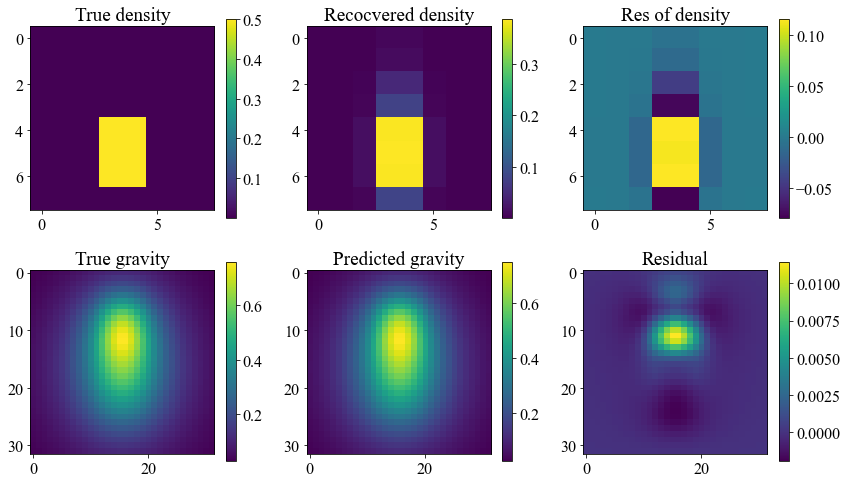

In [24]:
dep_index = 3
plt.figure(figsize=(12, 7))
plt.subplot(231)
plt.imshow(density[dep_index, :, :])
plt.title("True density")
plt.colorbar()

plt.subplot(232)
plt.imshow(res_lse[dep_index, :, :])
plt.title("Recocvered density")
plt.colorbar()

plt.subplot(233)
plt.imshow(density[dep_index, :, :]- res_lse[dep_index, :, :])
plt.title("Res of density")
plt.colorbar()

plt.subplot(234)
plt.imshow(gobs.reshape(nshape).T)
plt.title("True gravity")
plt.colorbar()

plt.subplot(235)
plt.imshow(predict.reshape(nshape).T)
plt.title("Predicted gravity")
plt.colorbar()

plt.subplot(236)
plt.imshow(gobs.reshape(nshape).T - predict.reshape(nshape).T)
plt.title("Residual")
plt.colorbar()
plt.tight_layout()

In [25]:
## 参数结果
paras = np.loadtxt('result.txt').T
paras.shape

(6, 1043)

In [26]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

C:\Users\DELL\AppData\Local\Temp\ipykernel_12644\2422025252.py:2: RuntimeWarning: overflow encountered in exp
  xarray = np.exp(np.array(paras[2]))+1e-9


RuntimeError: Error in qhull Delaunay triangulation calculation: input inconsistency (exitcode=1); use python verbose option (-v) to see original qhull error.

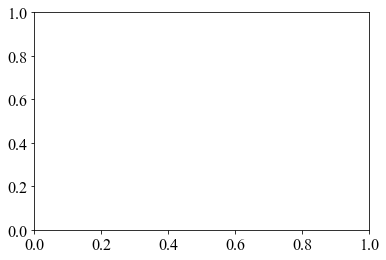

In [27]:
cmap = 'RdBu_r'
xarray = np.exp(np.array(paras[2]))+1e-9
yarray = np.exp(np.array(paras[3]))+1e-9
fig, ax = plt.subplots()
ax.tricontour(xarray, yarray, np.array(paras[5]), color = "k")
plot = ax.tricontourf(xarray, yarray, np.array(paras[5]), cmap=cmap)
plt.colorbar(plot, ax = ax)

In [ ]:
yarray

array([2.71828183e+000, 2.71828183e+000, 2.71828183e+000, 2.71828183e+000,
       2.71828187e+000, 2.71828183e+000, 1.58283614e+000, 1.58283614e+000,
       1.58283614e+000, 1.58283614e+000, 1.58283616e+000, 1.58283614e+000,
       3.41288683e-001, 9.89063972e-001, 9.89063972e-001, 9.89063972e-001,
       9.89063972e-001, 9.89063987e-001, 9.89063972e-001, 1.07121740e+000,
       1.07121740e+000, 1.07121740e+000, 1.07121740e+000, 1.07121742e+000,
       1.07121740e+000, 2.94538795e+000, 2.94538795e+000, 2.94538795e+000,
       2.94538795e+000, 2.94538800e+000, 2.94538795e+000, 2.06561672e+002,
       2.06561672e+002, 2.06561672e+002, 2.06561672e+002, 2.06561675e+002,
       2.06561672e+002, 4.56256909e+018, 1.14918925e+006, 1.14918925e+006,
       1.14918925e+006, 1.14918925e+006, 1.14918927e+006, 1.14918925e+006,
       1.33766957e+262, 4.64501676e+031, 3.51788481e+010, 1.96495061e+007,
       1.96495061e+007, 1.96495061e+007, 1.96495061e+007, 1.96495064e+007,
       1.96495061e+007, 2